 ## 확률적 경사 하강법
 - 대규모 데이터셋을 다룰 때 효율적으로 사용되는 최적화 알고리즘
 - 손실 함수(Loss Function)의 값을 최소화하기 위해 모델 파라미터를 조정하는 방법
 - 전체 데이터셋 대신 랜덤하게 선택된 하나의 데이터 포인트로만 파라미터를 업데이트
   - 매번 하나의 샘플을 무작위로 선택해서 그 샘플만을 기반으로 경사를 계산하고 파라미터를 업데이트
 ### 점진적으로 학습해 처음부터 대량의 학습 데이터가 없어도 된다는것이 핵심이다.
   
### 에포크
- 확률적 경사 하강법에서 훈련 세트를 한 번 모두 사용하는 과정

### 미니배치 경사 하강법
- 여러 개의 샘플을 사용해 경사 하강법을 수행하는 방법

### 배치 경사 하강법
- 극단적으로 한 번 경사로를 따라 이동하기 위해 전체 샘플 사용

## 손실 함수
- 어떤 문제에서 머신러닝 알고리즘의 성능 측정 기준
- 경사로란 손실 함수를 의미한다

### 로지스틱 손실 함수(이진 크로스엔트로피 손실 함수)
-  예측된 값과 실제 값의 차이를 기반으로 모델의 성능을 평가하는 데 사용
- 예측이 정확할수록 손실 값이 작고, 예측이 틀릴수록 손실 값이 커지도록 설계
  - 예를 들어, 실제 값이 1일 때 예측 값도 1에 가까우면 손실은 적고, 0에 가까우면 손실은 커진다.
- 다중 분류에선 크로스엔트로피 손실 함수가 사용된다.
- 이미 만들어진 클래스를 이용할것

In [31]:
# 파일 불러오기
import pandas as pd
import numpy as np

# x, y 분리
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

In [32]:
# 훈련, 테스트 데이터 분할
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

In [33]:
# 전처리(표준화)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [34]:
# 경사 하강법 클래스 import
from sklearn.linear_model import SGDClassifier

# 2 개의 매개변수 존재
# 1. loss: 손실 함수의 종류 지정, 여기선 'log_loss'로 지정해 로지스틱 손실 함수 지정
# 2. max_iter: 수행할 에포크 횟수 지정, 여기선 10회 반복
sc = SGDClassifier(loss="log", max_iter=10, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


C:\Users\computer\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [35]:
# 모델을 이어서 훈련할 땐 partial_fit()를 사용한다.
sc.partial_fit(train_scaled, train_target) # 한번 더 학습

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8151260504201681
0.85


## 에포크와 과대/과소적합
- 적은 에포크 수는 과소적합이 될 가능성이 있고,
- 많은 에포크 수는 훈련 데이터에 너무 잘 맞아 과대적합 될 가능성이 있다.
- 즉 에포크 진행 수에 따른 훈련 데이터와 테스트 데이터의 정확도를 비교해 최적의 에포크 반복 수를 찾아야한다.
  - 과대적합 시작 전 훈련을 멈추는것을 조기 종료라고 한다.

In [36]:
# 예제에서는 fit()이 아닌 partial_fit()을 사용
# 이유는 기존 학습 결과에서 추가로 반복하면서 학습시켜야하므로 
# 훈련 세트에 있는 전체 클래스의 레이블을 partial_fit() 메서드에 전달해줘야함
# np_unique() 함수로 train_target에 있는 7개 생선의 목록을 만들고, 에포크당 점수를 기록하기 위해 2개의 리스트를 준비함
sc = SGDClassifier(loss="log", random_state=42)
train_score = []
test_score = []
classes = np.unique(train_target)

In [37]:
# 반복 훈련 기록
for _ in range(0, 300):
    sc.partial_fit(train_scaled, train_target, classes=classes)
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

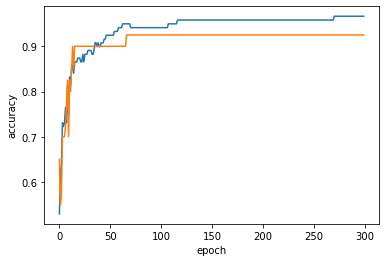

In [38]:
# 그래프로 그려보기
import matplotlib.pyplot as plt

plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- 결과를 보면(파:train, 주:test) 100번째 반복 이후 train과 test의 결과가 점점 벌어진다
- 에포크 초기에는 과소적합되어 정확도가 낮은것을 볼 수 있다.
- 최종적으로 확률적 경사 하강법의 반복 횟수를 100회로 정해서 다시 학습해본다

In [39]:
sc = SGDClassifier(loss="log", max_iter=100, tol=None, random_state=42)
# tol 매개변수를 None으로 주어 자동으로 멈추지 말고 100번 반복 진행
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.957983193277311
0.925


### 힌지 손실
- SGDClassifier의 loss 매개변수의 기본값은 hinge이다.
- 힌지손실은 서포트 벡터 머신이라 불리는 또 다른 머신러닝 알고리즘을 위한 손실함수이다.